# Truncation errors in linear fit calculations

I am fitting ten datapoints whose timestamps span a 100ms range, but with a baseline offset of about a week.
If I fit to the timestamps without first subtracting the baseline,
I get an incorrect answer for the gradient (over 3% error).

If I fit to the datapoints with the baseline subtracted, I get correct results.

This code demonstrates the issue and examines where the truncation error is causing problems

Classical formula for the gradient:
$$\frac{\overline{(xy)} - (\overline{x})(\overline{y})}{\overline{x^2} - \overline{x}^2}$$
Alternative formula:
$$\frac{\sum((x - \overline{x}) (y - \overline{y}))}{\sum (x - \overline{x})^2}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def linear(x, m, c):
    return m*x + c

In [3]:
baseline = 770656.892832
_t = np.array([0.440225, 0.45023,  0.460235, 0.470241, 0.480245, 0.490251, 0.500256, 0.510261, 0.520266, 0.530271])
t = baseline+_t
ph = np.array([568.1473, 568.4774, 568.7626, 569.0398, 569.234,  569.5013, 569.8461, 570.1536,  570.3557, 570.6171])

In [4]:
# This is the formula I used (which gives incorrect results when a large baseline is present)
# Note that this is the standard formula, which I teach and derive in the Numerical Methods course.
# It's the denominator that experiences the problem.
# We subtract two numbers that only differ in their 15th decimal digit,
# when double-precision numbers only have ~16 valid decimal digits.
def LinearFit(x, y):
    xMean = np.average(x)
    yMean = np.average(y)
    x2Mean = np.average(x**2)
    xyMean = np.average(x*y)
    beta = (xyMean - xMean * yMean) / (x2Mean - xMean**2)
    # Note that Matlab reports a true answer for the denominator as:
    # 0.00082584721749
    #print(x2Mean)
    #print(xMean**2)
    #print(x2Mean - xMean**2)
    alpha = yMean - beta * xMean
    return beta, alpha

# This equivalent formula (from Wikipedia) is not affected by the presence of the baseline
def LinearFit2(x, y):
    xMean = np.average(x)
    yMean = np.average(y)
    beta = np.sum((x - xMean) * (y - yMean)) / np.sum((x - xMean)**2)
    alpha = yMean - beta * xMean
    return beta, alpha

print("== Fit with baseline present ==")
lfBaseline = LinearFit(t, ph)
print(lfBaseline[0])
print("== Fit with baseline manually removed ==")
lfNoBaseline = LinearFit(t-baseline, ph)
print(lfNoBaseline[0])
print("== Alternative formula works with baseline present ==")
lf2Baseline = LinearFit2(t, ph)
print(lf2Baseline[0])

== Fit with baseline present ==
2.882568359375
== Fit with baseline manually removed ==
27.269338669345505
== Alternative formula works with baseline present ==
27.269338669422687


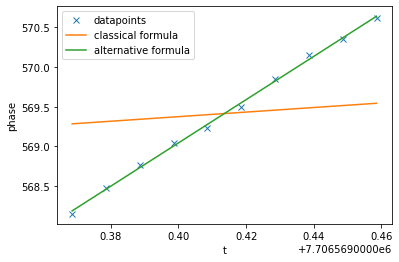

In [5]:
# Demonstrate the difference in linear fit
plt.plot(t, ph, 'x', label='datapoints')
plt.plot(t, linear(t, *lfBaseline), label='classical formula')
plt.plot(t, linear(t-baseline, *lfNoBaseline), label='alternative formula')
plt.ylabel("phase")
plt.xlabel("t")
plt.legend()
plt.savefig('linear.png')
plt.show()

# Algebraic rearrangements of the formula to understand where the truncation errors are coming from

In [6]:
# Confirming that my expanding of the x2Mean term matches the original (it does)
print(np.average(_t**2) + baseline**2 + 2*baseline*np.average(_t))
# Confirming that my expanding of the xMean**2 term matches the original (it does)
print((baseline)**2 + 2*baseline*np.average(_t) + np.average(_t)**2)

# Therefore all the baseline terms cancel (as they logically should) and the true difference between these two is:
denom = np.average(_t**2) - np.average(_t)**2
print(denom)

# But what this tells us is that the arithmetic has to be able to cope with subtracting two values
# of magnitude baseline**2 that only differ by an amount of the order of the *differences* between time values.
# This therefore requires a very large number of digits of precision
print((np.average(t*ph) - np.average(t) * np.average(ph)) / denom)

59391212126143.37
59391212126143.37
0.0008258472174900444
27.26904544894064


# Note that curve_fit does also run into similar problems, albeit to a slightly lesser extent

In [7]:
popt, pcov = curve_fit(linear, t, ph)
popt2, pcov2 = curve_fit(linear, t-baseline, ph)

# These two gradients differ in the second decimal place (0.1% error)
print(f"curve_fit gradient: {popt[0]}")
print(f"curve_fit gradient (baseline subtracted): {popt2[0]}")

curve_fit gradient: 27.25773600465059
curve_fit gradient (baseline subtracted): 27.269339975962076
